In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score

In [2]:
# 한글 폰트 깨지지 않게 하기
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 실행결과 경고메시지 출력 제외
import warnings

warnings.filterwarnings('ignore')

### 전처리

In [12]:
df = pd.read_csv("../01.files/02.Bigsata_analysis/체질검사.csv", encoding = 'euc-kr')
df.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER
0,35.2,46,363.15 lb,72.25 inch,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,남성
1,11.8,27,168 lb,71.25 inch,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,남성
2,22.2,69,177.75 lb,68.5 inch,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,남성
3,10.6,57,147.75 lb,65.75 inch,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,여성
4,47.5,51,219 lb,64 inch,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,여성


In [13]:
df[['WEIGHT', 'WEIGHT_UNIT']] = df['WEIGHT'].str.split(expand = True)
df[['HEIGHT', 'HEIGHT_UNIT']] = df['HEIGHT'].str.split(expand = True)
df['WEIGHT'] = df['WEIGHT'].astype('float64')
df['HEIGHT'] = df['HEIGHT'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FAT          252 non-null    float64
 1   AGE          252 non-null    int64  
 2   WEIGHT       252 non-null    float64
 3   HEIGHT       252 non-null    float64
 4   NECK         252 non-null    float64
 5   CHEST        252 non-null    float64
 6   ABDOMEN      252 non-null    float64
 7   HIP          252 non-null    float64
 8   THIGH        252 non-null    float64
 9   KNEE         252 non-null    float64
 10  ANKLE        252 non-null    float64
 11  BICEPS       252 non-null    float64
 12  FOREARM      252 non-null    float64
 13  WRIST        252 non-null    float64
 14  GENDER       252 non-null    object 
 15  WEIGHT_UNIT  252 non-null    object 
 16  HEIGHT_UNIT  252 non-null    object 
dtypes: float64(13), int64(1), object(3)
memory usage: 33.6+ KB


In [16]:
df = df.drop(['WEIGHT_UNIT', 'HEIGHT_UNIT'], axis = 1)

In [17]:
df.isnull().sum()

FAT        0
AGE        0
WEIGHT     0
HEIGHT     0
NECK       0
CHEST      0
ABDOMEN    0
HIP        0
THIGH      0
KNEE       0
ANKLE      0
BICEPS     0
FOREARM    0
WRIST      0
GENDER     0
dtype: int64

In [19]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER_여성
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,0
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,0
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,0
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,1
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FAT        252 non-null    float64
 1   AGE        252 non-null    int64  
 2   WEIGHT     252 non-null    float64
 3   HEIGHT     252 non-null    float64
 4   NECK       252 non-null    float64
 5   CHEST      252 non-null    float64
 6   ABDOMEN    252 non-null    float64
 7   HIP        252 non-null    float64
 8   THIGH      252 non-null    float64
 9   KNEE       252 non-null    float64
 10  ANKLE      252 non-null    float64
 11  BICEPS     252 non-null    float64
 12  FOREARM    252 non-null    float64
 13  WRIST      252 non-null    float64
 14  GENDER_여성  252 non-null    uint8  
dtypes: float64(13), int64(1), uint8(1)
memory usage: 27.9 KB


### 데이터 구성

In [21]:
df_y = df['FAT']
df_x = df.drop(['FAT'], axis = 1, inplace=False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size=0.3, random_state=777)

print("df_train_x:",df_train_x.shape)
print("df_test_x:",df_test_x.shape)
print("df_train_y:",df_train_y.shape)
print("df_test_y:",df_test_y.shape)

df_train_x: (176, 14)
df_test_x: (76, 14)
df_train_y: (176,)
df_test_y: (76,)


### 모델 구성

In [27]:
ridge = Ridge(random_state=777, alpha = 1)
ridge.fit(df_train_x, df_train_y)

print(ridge.intercept_)

df_ridge_coef = pd.DataFrame({"Coef": ridge.coef_}, index = df_train_x.columns)
df_ridge_coef

-17.723265982759113


,Coef
AGE,0.041103
WEIGHT,-0.097131
HEIGHT,-0.099130
NECK,-0.605584
CHEST,0.006881
ABDOMEN,0.980185
HIP,-0.240455
THIGH,0.201940
KNEE,-0.020947
ANKLE,0.413873


<Axes: >

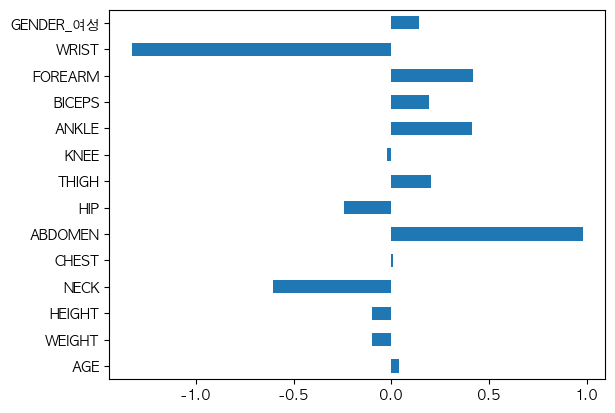

In [28]:
df_ridge_coef.plot.barh(y = "Coef", legend = False)

In [29]:
train_pred = ridge.predict(df_train_x)
test_pred = ridge.predict(df_test_x)
print("train data의 결정계수:", r2_score(df_train_y, train_pred))
print("test data의 결정계수:", r2_score(df_test_y, test_pred))

train data의 결정계수: 0.7519819801884531
test data의 결정계수: 0.7245325791700679


In [30]:
lasso = Lasso(random_state=777, alpha = 1)
lasso.fit(df_train_x, df_train_y)

print(lasso.intercept_)

df_lasso_coef = pd.DataFrame({"Coef": lasso.coef_}, index = df_train_x.columns)
df_lasso_coef

-37.332664955628445


,Coef
AGE,0.000000
WEIGHT,-0.127440
HEIGHT,-0.092303
NECK,-0.026527
CHEST,0.000000
ABDOMEN,0.919768
HIP,-0.000000
THIGH,0.025109
KNEE,0.000000
ANKLE,0.000000


<Axes: >

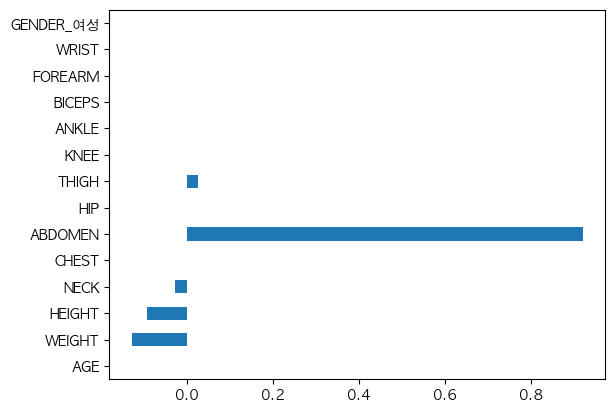

In [31]:
df_lasso_coef.plot.barh(y = "Coef", legend = False)

In [32]:
train_pred = lasso.predict(df_train_x)
test_pred = lasso.predict(df_test_x)
print("train data의 결정계수:", r2_score(df_train_y, train_pred))
print("test data의 결정계수:", r2_score(df_test_y, test_pred))

train data의 결정계수: 0.7223051068258712
test data의 결정계수: 0.7177022754648157


In [33]:
elastic = ElasticNet(random_state=777, alpha = 1)
elastic.fit(df_train_x, df_train_y)

print(elastic.intercept_)

df_elastic_coef = pd.DataFrame({"Coef": elastic.coef_}, index = df_train_x.columns)
df_elastic_coef

-32.711007506832985


,Coef
AGE,0.008686
WEIGHT,-0.119104
HEIGHT,-0.110757
NECK,-0.290369
CHEST,0.000000
ABDOMEN,0.923779
HIP,-0.052414
THIGH,0.096857
KNEE,0.000000
ANKLE,0.000000


<Axes: >

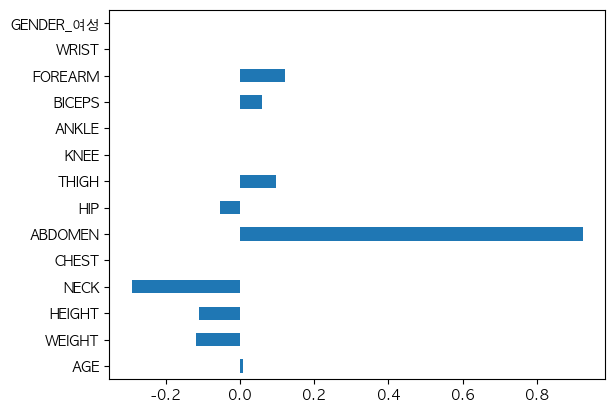

In [34]:
df_elastic_coef.plot.barh(y = "Coef", legend = False)

In [35]:
train_pred = elastic.predict(df_train_x)
test_pred = elastic.predict(df_test_x)
print("train data의 결정계수:", r2_score(df_train_y, train_pred))
print("test data의 결정계수:", r2_score(df_test_y, test_pred))

train data의 결정계수: 0.733927988106248
test data의 결정계수: 0.7225059078539453


In [46]:
alpha_tune = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
train_v = []
test_v = []
for a in alpha_tune:

    ridge = Ridge(random_state=777, alpha = a)
    ridge.fit(df_train_x, df_train_y)
    
    train_pred = ridge.predict(df_train_x)
    test_pred = ridge.predict(df_test_x)
    print("Alpha : ", a)
    print("train data의 결정계수:", r2_score(df_train_y, train_pred))
    print("test data의 결정계수:", r2_score(df_test_y, test_pred))
    print()

    train_v.append(r2_score(df_train_y, train_pred))
    test_v.append(r2_score(df_test_y, test_pred))

Alpha :  0.01
train data의 결정계수: 0.7519850480385838
test data의 결정계수: 0.7245864719715832

Alpha :  0.05
train data의 결정계수: 0.7519850403670844
test data의 결정계수: 0.7245843366729499

Alpha :  0.1
train data의 결정계수: 0.7519850164617237
test data의 결정계수: 0.7245816619897638

Alpha :  0.15
train data의 결정계수: 0.7519849767469096
test data의 결정계수: 0.7245789812302773

Alpha :  0.2
train data의 결정계수: 0.7519849213260772
test data의 결정계수: 0.7245762945021283

Alpha :  0.3
train data의 결정계수: 0.7519847637764201
test data의 결정계수: 0.7245709035654038

Alpha :  0.4
train data의 결정계수: 0.7519845446256025
test data의 결정계수: 0.7245654900208405

Alpha :  0.5
train data의 결정계수: 0.7519842646749638
test data의 결정계수: 0.7245600546941062

Alpha :  0.6
train data의 결정계수: 0.7519839247145166
test data의 결정계수: 0.7245545983955597

Alpha :  0.7
train data의 결정계수: 0.7519835255231266
test data의 결정계수: 0.7245491219205309

Alpha :  0.8
train data의 결정계수: 0.7519830678686901
test data의 결정계수: 0.7245436260495925

Alpha :  0.9
train data의 결정계수: 0.7519825

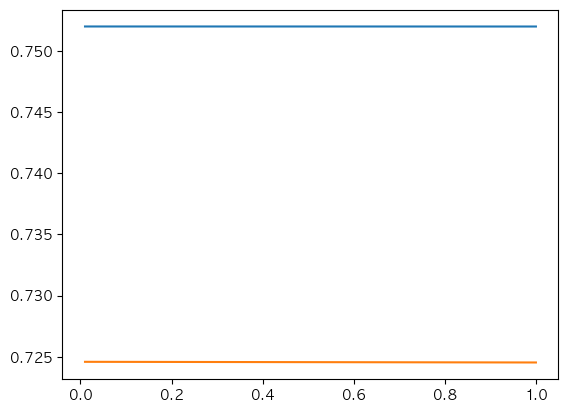

In [47]:
plt.plot(alpha_tune, train_v)
plt.plot(alpha_tune, test_v)
plt.show()